# Shanice's version from Ryan's SOSE code

# SOSE Heat Budget

Evaluating the conservation of heat content in the Southern Ocean State Estimate 

Author: [Shanice Bailey](https://github.com/stb2145)

![SOSE Logo](http://sose.ucsd.edu/images/SOSEpic.png)

In [144]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

## Open SOSE Dataset from Gyre

In [145]:
from dask.distributed import Client, LocalCluster, progress
cluster = LocalCluster(n_workers=4, threads_per_worker=8, ip='*')
client = Client(cluster)
client

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://129.236.21.48:33820 Dashboard: http://129.236.21.48:40476/status,Cluster Workers: 4 Cores: 32 Memory: 480.84 GB


In [146]:
ds = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

Optimization trick from Ryan's NB: split ds into coords and data variables then drop coordinates from data variables.

In [4]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [ ]:
coords

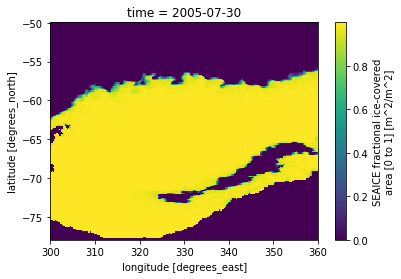

In [109]:
dsr.SIarea.sel(time='2005-08-01', method='nearest').sel(XC=slice(300, 360), YC=slice(-80,-50)).load().plot()

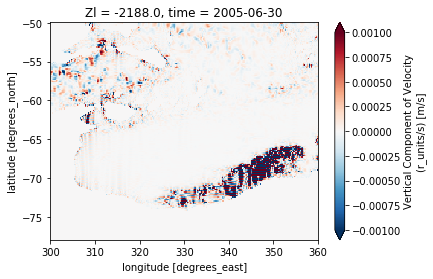

In [114]:
dsr.WVEL.sel(time='2005-07-01', Zl=-2100, method='nearest'
            ).sel(XC=slice(300, 360), YC=slice(-80,-50)).load().plot(vmax=1e-3)

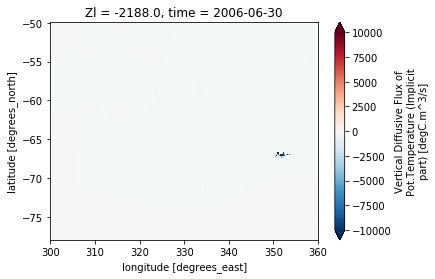

In [124]:
dsr.DFrI_TH.sel(time='2006-07-01', Zl=-2100, method='nearest'
            ).sel(XC=slice(300, 360), YC=slice(-80,-50)).load().plot(vmax=1e4)

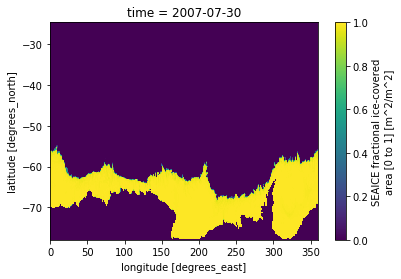

In [99]:
dsr.SIarea.sel(time='2007-08-01', method='nearest').load().plot()

## Create XGCM Grid

In [5]:
import xgcm
grid = xgcm.Grid(ds, periodic=('XC', 'YC'))
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center

## Tracer Budgets

Here we will do the heat budget for SOSE. In integral form, this budget can be written as

$$
\mathcal{V} \frac{\partial \theta}{\partial t} = G^\theta_{adv} + G^\theta_{diff} + G^\theta_{surf} + G^\theta_{linfs} + G^\theta_{sw}
$$

where $\mathcal{V}$ is the volume of the grid cell. The terms on the right-hand side are called _tendencies_. They add up to the total tendency (the left hand side).

The first term is the convergence of advective fluxes. The second is the convergence of diffusive fluxes. The third is the explicit surface flux. The fourth is the correction due to the linear free-surface approximation. The fifth is shortwave penetration (only for temperature).

### Flux Divergence

First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be eventually repeated for both tracers.

## Heat component of buoyancy budget integrated over Weddell Sea Region
Here, $\mathcal{V}$, represents the closed system of the Weddell Sea.

$$
\int_{R}{\frac{\partial{\theta}}{\partial{t}}}d\mathcal{V} = -\int_{NB}F^{\theta}_{adv,y}dA - \int_{NB} F^{\theta}_{diff,y}dA - \int_{surf}F^{\theta}_{surf}\vert_{z=0}dA
$$

where 'NB' denotes northern boundary of region R; 'surf' represents the boundary closed by the ocean surface; and $F^{\theta}_{surf}$ term includes the above $G^{\theta}_{surf}$ and $G^{\theta}_{sw}$. Both the first term and second term represents the the northern boundary crossing of the meridional advective flux and meridional diffusive flux, respectively; and the last term represents the surface flux crossing the ocean surface area.

Left-hand side can be written as: $\mathcal{V}\frac{\partial{\theta}}{\partial{t}}$ since $V = \int_{R}\mathcal{H}(\tilde{\theta} - \theta)\ dV$

In [ ]:
coords.rAs

In [ ]:
#adv flux terms already take into acct cell area (look at the units)
dsr.ADVy_TH

In [ ]:
dsr.TFLUX

In [ ]:
first_term = dsr.ADVy_TH.sel(YG=-60, method='nearest') + dsr.ADVx_TH.sel(XG=0, method='nearest')
second_term = dsr.DFyE_TH.sel(YG=-60, method='nearest') + dsr.DFxE_TH.sel(XG=-60, method='nearest')
third_term = dsr.TFLUX.sel(XC=slice(290,360), YC=slice(-80,-60))

In [ ]:
first_term

In [ ]:
import timeit

In [ ]:
#zooming in to WG region
#Longitude is closed boundary
#Latitude is not closed boundary
%timeit test = first_term.sel(XC=slice(290, 360), YC=slice(-80, -60)).sum(dim=('XC', 'YC', 'Z')).load()

In [ ]:
test = first_term.sel(XC=slice(290, 360), YC=slice(-80, -60)).sum(dim=('XC', 'YC', 'Z')).load()
test

In [ ]:
test.plot(figsize=(12,6))
plt.xlim('2005', '2011')
plt.grid();

In [ ]:
heat_budget = - first_term - second_term - third_term
heat_budget

In [ ]:
%timeit heat_budget_weddell = heat_budget.sel(XC=slice(290,360), YC=slice(-80,-60)).sum(dim=('XC', 'YC', 'Z')).load()

In [ ]:
heat_budget_weddell = heat_budget.sel(XC=slice(290,360), YC=slice(-80,-60)).sum(dim=('XC', 'YC', 'Z')).load()
heat_budget_weddell

In [ ]:
heat_budget_weddell.plot(figsize=(12,6))
plt.grid()
plt.xlim('2005', '2011')
plt.ylim(heat_budget_weddell.min(), heat_budget_weddell.max());

In [ ]:
heat_budget_weddell_mm = heat_budget_weddell.groupby('time.month').mean(dim='time')
heat_budget_weddell_anom = heat_budget_weddell.groupby('time.month') - heat_budget_weddell_mm
heat_budget_weddell_anom

In [ ]:
#why rolling 30?
heat_budget_weddell_anom.rolling(time=30).mean().plot(figsize=(12,6))
plt.grid()
plt.xlim('2005', '2011')
plt.axhline(y=0, color='k')
plt.title('Weddell Sea Heat Budget Anomaly')
plt.ylabel(r'˚C $\frac{m^3}{s}$');

In [ ]:
dsr

# Heat budget for Weddell Gyre

In [6]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()

In [7]:
surface_mask = (coords.hFacC[0]>0).load()

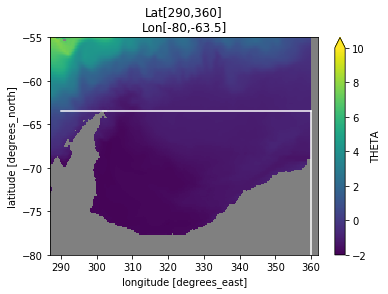

In [8]:
fig, ax = plt.subplots(subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([290, 360], [-63.5, -63.5], color='w')
ax.plot([360, 360], [-80, -63.5], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Lat[290,360]\nLon[-80,-63.5]');

In [9]:
#set the boundaries
lat_range = dict(YC=slice(-80, -63.4583))
lon_range = dict(XC=slice(290, 360))

In [10]:
dsr.ADVy_TH.sel(YG=-63.5, method='nearest')

<xarray.DataArray 'ADVy_TH' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YG       float32 -63.4583
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Advective Flux of Pot.Temperature
    mate:           ADVx_TH
    standard_name:  ADVy_TH
    units:          degC.m^3/s

In [147]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range).sel(YG=-63.4583, method='nearest').sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range).sel(XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([  633104.75, 12283328.  , 16294197.  , ..., 24365692.  , 23381524.  ,
       20343450.  ], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -63.4583

In [12]:
yg_index = dsr.indexes['YG']
yg_index.get_loc(-60, method='nearest')

108

In [13]:
adv_flux_y

<xarray.DataArray 'ADVy_TH' (time: 438)>
array([ 4585181.5, 15053348. , 18469256. , ..., 27620050. , 26147492. ,
       24032264. ], dtype=float32)
Coordinates:
    YG       float32 -63.4583
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [14]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range).sel(YG=-63.4583, method='nearest').sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range).sel(XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 35644.74,  18859.55,  39135.4 , ..., 130287.34, 127106.91, 122110.78],
      dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -63.4583

In [15]:
#vertical flux
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([1.021158e+14, 1.281988e+14, 1.416707e+14, ..., 1.111411e+14,
       1.253413e+14, 1.688571e+14], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [16]:
coords.rA.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'rA' (XC: 2160)>
dask.array<shape=(2160,), dtype=float32, chunksize=(2160,)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [17]:
dsr.WTHMASS.sel(YC=-63.4583, method='nearest')

<xarray.DataArray 'WTHMASS' (time: 438, Zl: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    standard_name:  WTHMASS
    units:          degC.m/s

In [18]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(-80, -63.541634)).sum(dim=['XC', 'YC'])
#lin_fs_correction longitude window is slightly different than other terms
#units: (˚C m^3)/s

In [19]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([ 5179216.5 ,   398668.53, -2679960.8 , ...,  2118823.2 , -4036530.  ,
        2061171.2 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

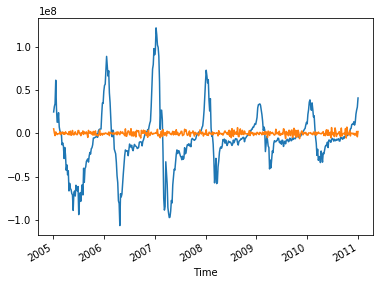

In [20]:
surface_term.plot()
lin_fs_correction.plot()

In [21]:
#is it hFacC or hFacS
total_volume = (coords.rA + coords.drF + coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(6.010579e+15, dtype=float32)

In [22]:
dsr.TOTTTEND.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [23]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, YC=slice(-80, -63.541634)).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#same longitudinal window as lin_fs_correction (63.541634)
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([30284118.85037 , 43322342.21037 , 46187300.02963 , ..., 34259532.61037 ,
       36654515.38963 , 50856758.234074])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

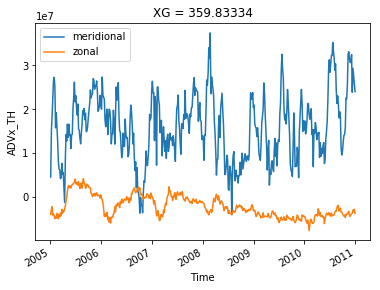

In [24]:
adv_flux_y.plot(label='meridional')
adv_flux_x.plot(label='zonal')
plt.legend();

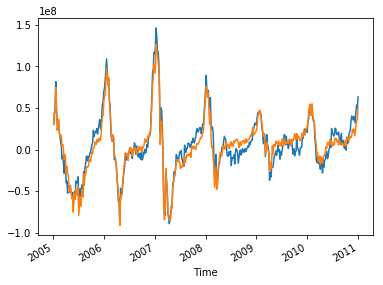

In [25]:
rhs = + adv_flux + diff_flux +  lin_fs_correction + surface_term
lhs = tottend_weddell
rhs.plot()
lhs.plot()

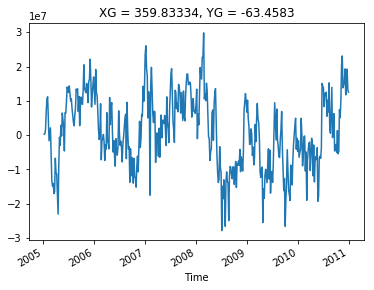

In [26]:
(rhs - lhs).plot()

In [27]:
(rhs - lhs).mean()

<xarray.DataArray ()>
array(1000918.251389)
Coordinates:
    XG       float32 359.83334
    YG       float32 -63.4583

In [28]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -63.4583
Data variables:
    tottend    (time) float64 3.028e+07 4.332e+07 ... 3.665e+07 5.086e+07
    adv_flux   (time) float32 633104.75 12283328.0 ... 23381524.0 20343450.0
    diff_flux  (time) float32 35644.74 18859.55 39135.4 ... 127106.91 122110.78
    lin_fs     (time) float32 5179216.5 398668.53 ... -4036530.0 2061171.2
    surface    (time) float32 24702700.0 31012410.0 ... 30321152.0 40848020.0

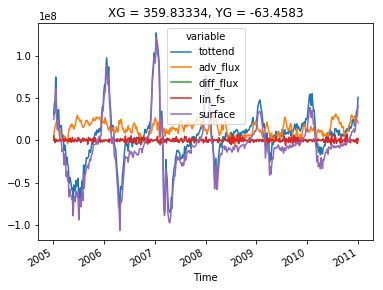

In [29]:
all_terms.to_array().plot.line(x='time')

In [30]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,4.768913e+06
adv_flux,1.375057e+07
diff_flux,7.324439e+04
lin_fs,-2.981882e+04
surface,-8.024168e+06


In [31]:
rhs_minus_lhs = df.iloc[0] - df.iloc[1:].sum()
rhs_minus_lhs

budget   -1.000919e+06
dtype: float64

In [32]:
budget_diff = rhs.sum() - lhs.sum()
budget_diff

<xarray.DataArray ()>
array(4.384019e+08)
Coordinates:
    XG       float32 359.83334
    YG       float32 -63.4583

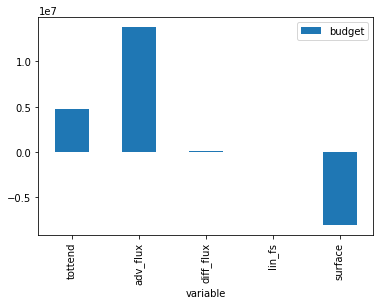

In [33]:
df.plot(kind='bar')

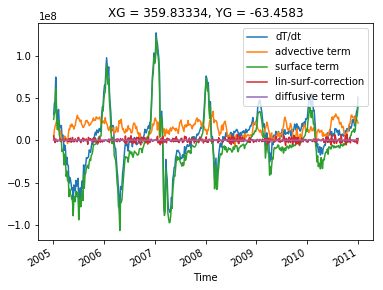

In [34]:
tottend_weddell.plot(label='dT/dt')
adv_flux.plot(label='advective term')
surface_term.plot(label='surface term')
lin_fs_correction.plot(label='lin-surf-correction')
diff_flux.plot(label='diffusive term')
plt.legend();

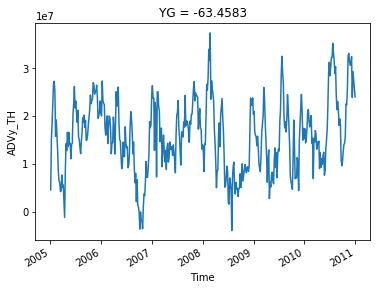

In [35]:
adv_flux_y.plot()

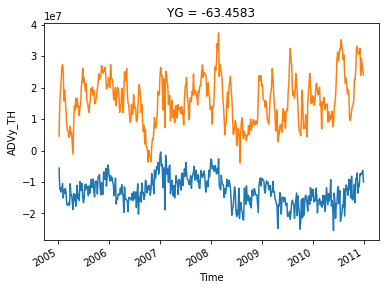

In [36]:
(surface_term - tottend_weddell).plot()
adv_flux_y.plot(label='adv flux y')

In [37]:
test = surface_term - tottend_weddell
test

<xarray.DataArray (time: 438)>
array([ -5581418.85037 , -12309932.21037 , -11915924.02963 , ...,
        -7373520.61037 ,  -6333363.38963 , -10008738.234074])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [38]:
dsr.TOTTTEND

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

# Heat budget for lower part of WG

## Heat component of buoyancy budget integrated over lower Weddell Sea Region
Here, $\mathcal{V}$, represents the closed system of the Weddell Sea.

$$
\int_{R}{\frac{\partial{\theta}}{\partial{t}}}d\mathcal{V} = -\int_{NB}F^{\theta}_{adv,\mathbf{x}}dA - \int_{NB} F^{\theta}_{diff,\mathbf{x}}dA
$$

where 'NB' denotes northern boundary of region R; and the $F^{\theta}_{diff}$ term includes the explicit, implicit and KPP variables from SOSE dataset.

In [39]:
#set the boundaries
lat_range = dict(YC=slice(-80, -60))
lon_range = dict(XC=slice(290, 360))
lower_cell_range = dict(Z=slice(-2e03, -5.575e03))

In [40]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range, **lower_cell_range).sel(YG=-60, method='nearest'
                                                                 ).sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range, **lower_cell_range).sel(XG=360, method='nearest'
                                                                 ).sum(dim=['YC', 'Z']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-13310190. ,   8101754. ,  12560044. , ...,  10995880. ,   7511841. ,
         8177555.5], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -59.9583

In [41]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range, **lower_cell_range).sel(YG=-60, method='nearest'
                                                                  ).sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range, **lower_cell_range).sel(XG=360, method='nearest'
                                                                  ).sum(dim=['YC', 'Z']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-24170.133 ,   5649.919 , -30633.68  , ...,  16922.201 ,  11428.421 ,
         7512.0264], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -59.9583

In [42]:
#vertical flux
#slice for z for this term?
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([2.183112e+14, 2.600259e+14, 2.185133e+14, ..., 3.302395e+14,
       3.279043e+14, 3.643701e+14], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [43]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(-80, -60)).sum(dim=['XC', 'YC'])
#units: (˚C m^3)/s

In [44]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([34009980.  ,  -501511.62, -4915518.  , ...,  2207332.5 , -5533959.5 ,
        3560072.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

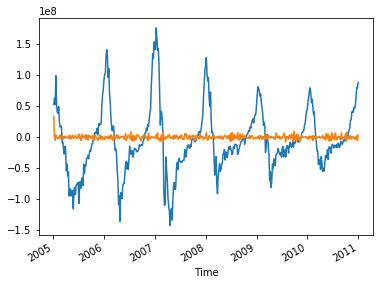

In [45]:
surface_term.plot()
lin_fs_correction.plot()

In [46]:
#is it hFacC or hFacS
total_volume = (coords.rA + coords.drF + coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(6.010579e+15, dtype=float32)

In [47]:
dsr.TOTTTEND

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [48]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#same longitudinal window as lin_fs_correction
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([65429595.022222, 70549249.137778, 57274440.817778, ..., 77866847.194074,
       76623975.158519, 91236913.303704])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

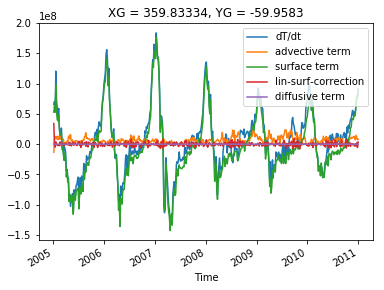

In [49]:
tottend_weddell.plot(label='dT/dt')
adv_flux.plot(label='advective term')
surface_term.plot(label='surface term')
lin_fs_correction.plot(label='lin-surf-correction')
diff_flux.plot(label='diffusive term')
plt.legend();

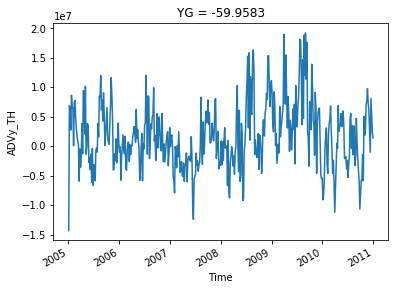

In [50]:
adv_flux_y.plot()

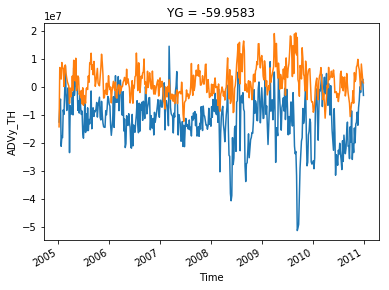

In [51]:
(surface_term - tottend_weddell).plot()
adv_flux_y.plot(label='adv flux y')

In [52]:
sst_mean = dsr.THETA.sel(Z=slice(-2e03, -5.575e03)).mean(dim=['time', 'Z']).load()

In [53]:
coords.hFacC.sel(Z=-2e03, method='nearest')

<xarray.DataArray 'hFacC' (YC: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Z        float32 -2046.0
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction

In [54]:
surface_mask = (coords.hFacC.sel(Z=-2046.0)>0).load()

** DRY = don't repeat yourself **

In [135]:
left_lon = 295
upper_lat = -63.5
right_lon = 360
lower_lat =-80

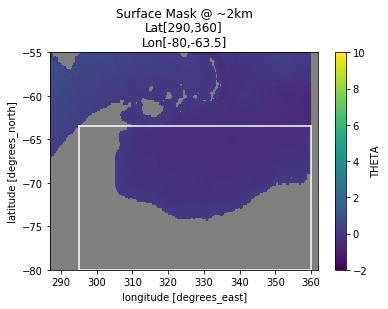

In [148]:
fig, ax = plt.subplots(subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [149]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lower_cell_range = dict(Z=slice(-2e03, -5.575e03))

In [57]:
dsr.ADVy_TH.sel(YG=-63.5, method='nearest')

<xarray.DataArray 'ADVy_TH' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YG       float32 -63.4583
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Advective Flux of Pot.Temperature
    mate:           ADVx_TH
    standard_name:  ADVy_TH
    units:          degC.m^3/s

In [58]:
dsr.ADVx_TH.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'ADVx_TH' (time: 438, Z: 42, XG: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
    YC       float32 -63.541634
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Zonal      Advective Flux of Pot.Temperature
    mate:           ADVy_TH
    standard_name:  ADVx_TH
    units:          degC.m^3/s

In [59]:
dsr.ADVr_TH.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'ADVr_TH' (time: 438, Zl: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical   Advective Flux of Pot.Temperature
    standard_name:  ADVr_TH
    units:          degC.m^3/s

In [60]:
dsr.ADVr_TH.sel(Zl=-2.1e03, method='nearest')

<xarray.DataArray 'ADVr_TH' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Zl       float32 -2188.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical   Advective Flux of Pot.Temperature
    standard_name:  ADVr_TH
    units:          degC.m^3/s

In [ ]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range, **lower_cell_range).sel(YG=-63.4583, method='nearest'
                                                                 ).sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range, **lower_cell_range).sel(XG=360, method='nearest'
                                                                 ).sum(dim=['YC', 'Z']).load()
adv_flux_z = dsr.ADVr_TH.sel(**lon_range, **lat_range).sel(Zl=-2.1e03, method='nearest'
                                                          ).sum(dim=['XC', 'YC']).load()
adv_flux_lower = adv_flux_x + adv_flux_y + adv_flux_z
adv_flux_lower.load()
#units: (˚C m^3)/s

In [151]:
dsr.VVEL

<xarray.DataArray 'VVEL' (time: 438, Z: 42, YG: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Component of Velocity (m/s)
    mate:           UVEL
    standard_name:  VVEL
    units:          m/s

In [152]:
vol_flux_y = (dsr.VVEL * coords.dxG * coords.drF * coords.hFacS).sel(**lon_range, **lower_cell_range).sel(YG=-63.4583, method='nearest'
                                                                 ).sum(dim=['XC', 'Z']).load()

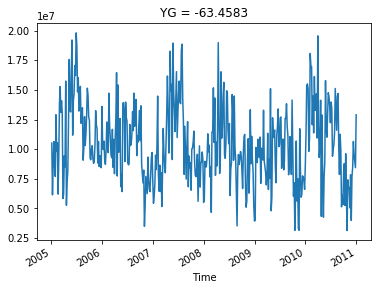

In [153]:
vol_flux_y.plot()

In [103]:
vol_flux_z = (dsr.WVEL * coords.rA).sel(**lon_range, **lat_range).sel(Zl=-2.1e03, method='nearest'
                                                          ).sum(dim=['XC', 'YC']).load()

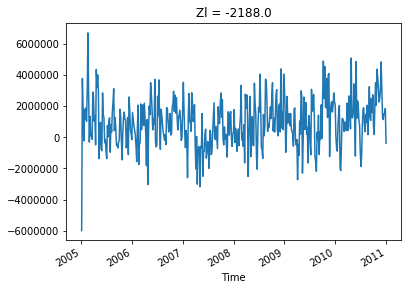

In [104]:
vol_flux_z.plot()

In [105]:
# approximately true
ADVr_TH_approx = (dsr.WVEL * dsr.THETA * coords.rA)
# difference is numerical effects
adv_flux_z_approx = ADVr_TH_approx.sel(**lon_range, **lat_range).sel(Zl=-2.1e03, method='nearest'
                                                          ).sum(dim=['XC', 'YC']).load()


In [ ]:
vol_flux_x = dsr.ADVx_TH.sel(**lat_range, **lower_cell_range).sel(XG=360, method='nearest'
                                                                 ).sum(dim=['YC', 'Z']).load()
vol_flux_z = dsr.ADVr_TH.sel(**lon_range, **lat_range).sel(Zl=-2.1e03, method='nearest'
                                                          ).sum(dim=['XC', 'YC']).load()
mass_flux_

In [62]:
dsr.DFrE_TH.sel(Zl=-2.1e03, method='nearest')

<xarray.DataArray 'DFrE_TH' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Zl       float32 -2188.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Diffusive Flux of Pot.Temperature (Explicit part)
    standard_name:  DFrE_TH
    units:          degC.m^3/s

In [63]:
dsr.DFrI_TH.sel(Zl=-2.1e03, method='nearest')

<xarray.DataArray 'DFrI_TH' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Zl       float32 -2188.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Diffusive Flux of Pot.Temperature (Implicit part)
    standard_name:  DFrI_TH
    units:          degC.m^3/s

In [64]:
dsr.KPPg_TH.sel(Zl=-2.1e03, method='nearest')

<xarray.DataArray 'KPPg_TH' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
    Zl       float32 -2188.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      KPP non-local Flux of Pot.Temperature
    standard_name:  KPPg_TH
    units:          degC.m^3/s

In [ ]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range, **lower_cell_range).sel(YG=-63.4583, method='nearest'
                                                                  ).sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range, **lower_cell_range).sel(XG=360, method='nearest'
                                                                  ).sum(dim=['YC', 'Z']).load()
diff_flux_z = (dsr.DFrE_TH.sel(**lon_range, **lat_range).sel(Zl=-2.1e03, method='nearest'
                                                           ).sum(dim=['XC', 'YC'])
              + dsr.DFrI_TH.sel(**lon_range, **lat_range).sel(Zl=-2.1e03, method='nearest'
                                                           ).sum(dim=['XC', 'YC'])
              + dsr.KPPg_TH.sel(**lon_range, **lat_range).sel(Zl=-2.1e03, method='nearest'
                                                           ).sum(dim=['XC', 'YC'])).load()
diff_flux_lower = diff_flux_x + diff_flux_y + diff_flux_z
diff_flux_lower.load()
#units: (˚C m^3)/s

In [155]:
#is it hFacC or hFacS
total_volume = (coords.rA + coords.drF + coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(6.010579e+15, dtype=float32)

In [156]:
dsr.TOTTTEND.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [157]:
tottend_weddell_lower = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, **lat_range, **lower_cell_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([65429595.022222, 70549249.137778, 57274440.817778, ..., 77866847.194074,
       76623975.158519, 91236913.303704])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

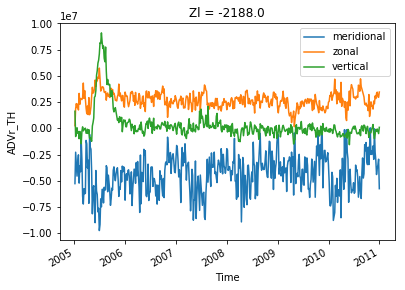

In [158]:
adv_flux_y.plot(label='meridional')
adv_flux_x.plot(label='zonal')
adv_flux_z.plot(label='vertical')
plt.legend();
#vertical is positive, i think that means upwelling (which there is considerable upwelling in the 
#WG region - fun exercise would be to figure out what region specifically is producing this upwelling)
#meridional is negative which probably means it's moving poleward 
#zonal is positive - why?

# spike doesn't rep real polynya in real ocean (only real in SOSE)

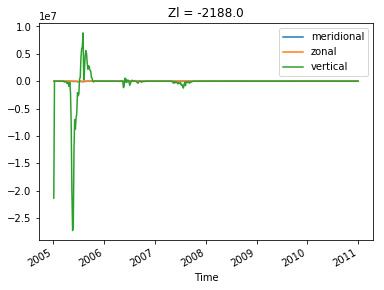

In [159]:
diff_flux_x.plot(label='meridional')
diff_flux_x.plot(label='zonal')
diff_flux_z.plot(label='vertical')
plt.legend();

In [ ]:
rhs = - (adv_flux + diff_flux) 
lhs = tottend_weddell_lower
rhs.plot(color='k')
lhs.plot(color='y')

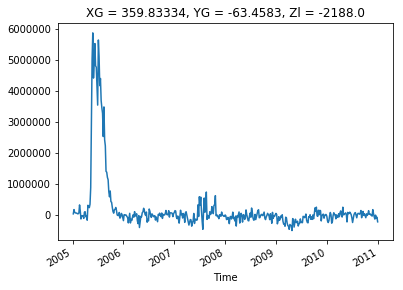

In [161]:
(rhs - lhs).plot()

In [162]:
(rhs - lhs).mean().load()

<xarray.DataArray ()>
array(188975.09227)
Coordinates:
    XG       float32 359.83334
    YG       float32 -63.4583
    Zl       float32 -2188.0

In [163]:
all_terms = xr.merge([tottend_weddell_lower.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -63.4583
    Zl         float32 -2188.0
Data variables:
    tottend    (time) float64 dask.array<shape=(438,), chunksize=(1,)>
    adv_flux   (time) float32 -3400441.0 -1182858.2 ... -498550.62 -2206952.5
    diff_flux  (time) float32 -21362840.0 2077.0156 ... -23486.285 -19315.398

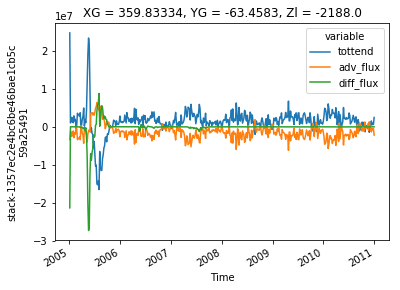

In [164]:
all_terms.to_array().plot.line(x='time')

In [91]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,1.457525e+06
adv_flux,-3.152544e+05
diff_flux,-2.842949e+05


In [165]:
rhs_minus_lhs = df.iloc[0] + df.iloc[1:].sum()
rhs_minus_lhs

budget    857975.937338
dtype: float64

In [166]:
budget_diff = rhs.sum() + lhs.sum()
budget_diff.load()

<xarray.DataArray ()>
array(1.347873e+09)
Coordinates:
    XG       float32 359.83334
    YG       float32 -63.4583
    Zl       float32 -2188.0

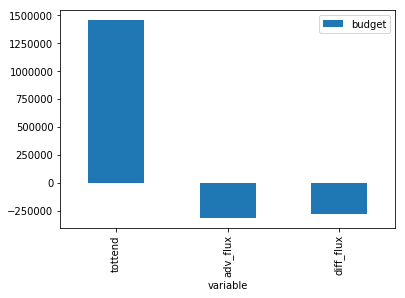

In [167]:
df.plot(kind='bar')


NameError: name 'adv_flux_lower' is not defined

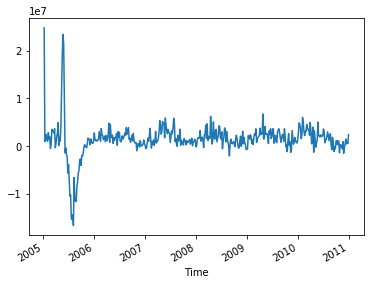

In [168]:
tottend_weddell_lower.plot(label='dT/dt')
adv_flux_lower.plot(label='advective term')
diff_flux_lower.plot(label='diffusive term')
plt.legend();
#expected to see diffusive term being more prominant in the lower WG region

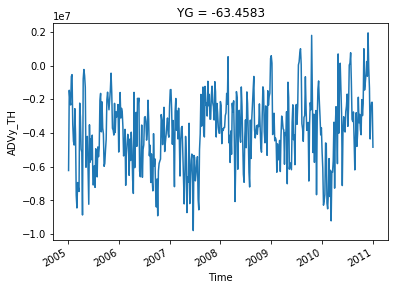

In [80]:
adv_flux_y.plot()

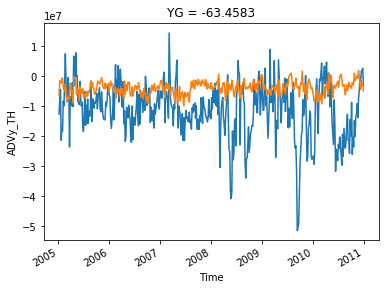

In [81]:
(surface_term - tottend_weddell).plot()
adv_flux_y.plot(label='adv flux y')

In [82]:
test = surface_term - tottend_weddell
test

<xarray.DataArray (time: 438)>
array([-12618211.022222,  -7646697.137778,  -4414148.817778, ...,
         2020984.805926,   2698944.841481,  -3092601.303704])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [ ]:
dsr.TOTTTEND

# Heat budget for full SO south of 55S

Weddell sea will be more complicate but similar.

We need to calculate
- the merional advective and diffusive fluxes across 55S.
- the surface fluxes for the whole region south of 55S.
- the total time rate of change of the temperature in this region.

In [ ]:
# advective flux
flux_across_55S = dsr.ADVy_TH.sel(YG=-55, method='nearest').sum(dim=['XC', 'Z'])
flux_across_55S

In [ ]:
# diffusive flux
diff_flux_across_55s = dsr.DFyE_TH.sel(YG=-55, method='nearest').sum(dim=['XC', 'Z']).load()

In [ ]:
# surface flux

In [ ]:
dsr.TFLUX.dims

In [ ]:
dsr.TFLUX.units

In [ ]:
tflux_south_of_55S = (dsr.TFLUX.sel(YC=slice(-90, -55)) * coords.rA).sum(dim=['XC', 'YC'])
tflux_south_of_55S

In [ ]:
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3
surface_term = tflux_south_of_55S / (heat_capacity_cp * runit2mass)

In [ ]:
lin_fs_correction_th = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                          ).sel(YC=slice(-90, -55)).sum(dim=['XC', 'YC'])

In [ ]:
lin_fs_correction_th.load()

In [ ]:
%time surface_term.load()

In [ ]:
surface_term.plot()
lin_fs_correction_th.plot()

In [ ]:
%time flux_across_55S.load()

In [ ]:
total_volume = (coords.rA * coords.drF * coords.hFacC).sum().load()
total_volume

In [ ]:
tottend_south_of_55s.mean() / total_volume
# units: degrees per day

In [ ]:
# net annual mean warming rate south of 55S for the whole SOSE period
(tottend_south_of_55s / (24*60*60)).mean() / 1e6
# units are 10^6 deg m^3 / s

In [ ]:
# rate that advection is working to change the temperature 
(-flux_across_55S).mean() / 1e6
# positive means advection is bringing in net heat

In [ ]:
# rate of surface heating / cooling
surface_term.mean() / 1e6
# negative means net cooling at the surface

In [ ]:
# total tendency
dsr.TOTTTEND

In [ ]:
tottend_south_of_55s = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
                        ).sel(YC=slice(-90, -55)).sum(dim=['XC', 'YC', 'Z'])
tottend_south_of_55s

In [ ]:
dsr.TOTTTEND

In [ ]:
tottend_south_of_55s.load()

In [ ]:
(tottend_south_of_55s / (24*60*60)).plot(label='dT/dt')
(-flux_across_55S).plot(label='Adv Flux Y')
#diff_flux_across_55s.plot()
surface_term.plot(label='surface flux')
plt.legend()

In [ ]:
(surface_term - tottend_south_of_55s / (24*60*60)).plot()
flux_across_55S.plot(label='Adv Flux Y')